
# Notebook 2: EDA y Preparación de Datos para Backtesting Momentum

Transforma datos diarios en estructuras mensuales optimizadas para:
- Implementación de estrategia (Notebook 3)
- Motor de backtesting (Notebook 4)
- Monte Carlo vectorizado (Notebook 5)

CRÍTICO: Todos los DataFrames en formato WIDE (fechas × tickers)
"""

## PARTE 1: CONFIGURACIÓN E IMPORTS

Esta sección configura el entorno de trabajo, importa las librerías necesarias y define las constantes críticas del pipeline de procesamiento.

**Decisiones clave:**
- **HISTORY_START = 13 meses antes de BACKTEST_START**: Se requiere un período histórico de 13 meses (12 meses para momentum + 1 mes de lag) antes del inicio del backtesting para calcular correctamente los retornos acumulados R_12 y R_6 en la primera fecha de rebalanceo.
- **FFILL_LIMIT = 5 días**: Límite conservador para forward fill que rellena gaps pequeños causados por holidays o suspensiones temporales, pero evita extender artificialmente la vida de activos delisted. Un límite mayor introduciría sesgo de supervivencia.
- **LAG_MONTHS = 1**: El lag de un mes evita el ruido de reversión a la media (short-term reversal) que afecta típicamente al mes inmediatamente posterior a períodos de alta volatilidad, mejorando la calidad de las señales de momentum.

In [7]:
# ============= IMPORTS =============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============= CONFIGURACIÓN =============
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

# Estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ============= CONSTANTES =============
# Rutas
DATA_RAW_DIR = '../datos/raw'
DATA_PROCESSED_DIR = '../datos/processed'

# Fechas críticas
HISTORY_START = '2013-12-01'  # Inicio para acumular histórico (13 meses antes de backtest)
BACKTEST_START = '2015-01-01'  # Inicio del backtesting
DATA_END = '2026-01-30'        # Fin de datos disponibles

# Parámetros de estrategia
MIN_MONTHS_HISTORY = 13  # 12 meses momentum + 1 lag
LAG_MONTHS = 1           # Lag para evitar reversión a la media
FFILL_LIMIT = 5          # Límite de días para forward fill

print("="*70)
print("NOTEBOOK 2: EDA Y PREPARACIÓN DE DATOS")
print("="*70)
print(f"Periodo histórico:  {HISTORY_START} a {DATA_END}")
print(f"Periodo backtesting: {BACKTEST_START} a {DATA_END}")
print(f"Min histórico requerido: {MIN_MONTHS_HISTORY} meses")
print(f"Lag momentum: {LAG_MONTHS} mes")

NOTEBOOK 2: EDA Y PREPARACIÓN DE DATOS
Periodo histórico:  2013-12-01 a 2026-01-30
Periodo backtesting: 2015-01-01 a 2026-01-30
Min histórico requerido: 13 meses
Lag momentum: 1 mes


## PARTE 2: CARGA Y ESTRUCTURACIÓN INICIAL

Esta sección carga los datos raw y los transforma al formato WIDE (fechas × tickers), optimizado para operaciones vectorizadas en backtesting.

**Decisiones clave:**
- **Formato WIDE (fechas × tickers)**: Permite operaciones vectorizadas eficientes con pandas/numpy, esencial para calcular retornos acumulados y aplicar filtros de elegibilidad sobre múltiples activos simultáneamente. Alternativas como formato LONG requerirían loops costosos.
- **Filtrado desde HISTORY_START**: Se descartan datos anteriores a 2013-12-01 para optimizar memoria y procesamiento, ya que solo se necesitan 13 meses de histórico antes del backtest. Esto reduce el dataset de ~7M a ~2M filas sin pérdida de información relevante.
- **Eliminación de timezone**: Se normaliza el índice temporal eliminando timezones para evitar inconsistencias en operaciones de resample y alineación temporal entre diferentes fuentes de datos.

In [8]:
# ============= CARGA DE DATOS =============
print("\n" + "="*70)
print("CARGANDO DATOS")
print("="*70)

# Cargar dataset completo
df_all = pd.read_parquet(f'{DATA_RAW_DIR}/tickers_data.parquet')
print(f"Dataset cargado: {df_all.shape}")
print(f"Rango fechas: {df_all.index.min()} a {df_all.index.max()}")
print(f"Tickers únicos: {df_all['symbol'].nunique()}")

# Cargar SPY
df_spy = pd.read_parquet(f'{DATA_RAW_DIR}/spy_data.parquet')
print(f"SPY cargado: {df_spy.shape}")

# ============= FILTRAR DESDE HISTORY_START =============
# Razón: Solo necesitamos datos desde 13 meses antes del backtest
if not isinstance(df_all.index, pd.DatetimeIndex):
    if 'date' in df_all.columns:
        df_all['date'] = pd.to_datetime(df_all['date'])
        df_all = df_all.set_index('date')
    else:
        raise ValueError("No se encuentra índice datetime ni columna 'date'.")

if not isinstance(df_spy.index, pd.DatetimeIndex):
    if 'date' in df_spy.columns:
        df_spy['date'] = pd.to_datetime(df_spy['date'])
        df_spy = df_spy.set_index('date')
    else:
        raise ValueError("SPY: No se encuentra índice datetime ni columna 'date'.")

# Eliminar timezone si existe
if df_all.index.tz is not None:
    df_all.index = df_all.index.tz_localize(None)
if df_spy.index.tz is not None:
    df_spy.index = df_spy.index.tz_localize(None)

df_all = df_all.sort_index()
df_spy = df_spy.sort_index()

df_all = df_all.loc[HISTORY_START:].copy()
df_spy = df_spy.loc[HISTORY_START:].copy()

print(f"\nDespués de filtrar desde {HISTORY_START}:")
print(f"  Dataset: {df_all.shape}")
print(f"  SPY: {df_spy.shape}")

# ============= CONSTRUIR DATAFRAMES WIDE =============
print("\n" + "="*70)
print("CONSTRUYENDO DATAFRAMES WIDE (fechas × tickers)")
print("="*70)

# Función helper para pivotear
def build_wide_dataframe(df: pd.DataFrame, value_column: str) -> pd.DataFrame:
    """
    Convierte DataFrame long a wide format.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame en formato long con columnas [date, symbol, value]
    value_column : str
        Nombre de la columna con valores (ej: 'close', 'open')
    
    Returns
    -------
    pd.DataFrame
        DataFrame wide (fechas × tickers)
    """
    wide = df.pivot_table(index=df.index, columns='symbol', values=value_column)
    # Ordenar columnas alfabéticamente para consistencia
    wide = wide.sort_index(axis=1)
    return wide

# Construir DataFrames wide
prices_close_wide = build_wide_dataframe(df_all, 'close')
prices_open_wide = build_wide_dataframe(df_all, 'open')

# Flag de pertenencia a S&P 500
in_sp500_wide = build_wide_dataframe(df_all, 'in_sp500')

print(f"Prices CLOSE wide: {prices_close_wide.shape}")
print(f"Prices OPEN wide:  {prices_open_wide.shape}")
print(f"In S&P 500 wide:   {in_sp500_wide.shape}")
print(f"Memoria CLOSE: {prices_close_wide.memory_usage().sum() / 1e6:.2f} MB")

# Verificación de formato
assert prices_close_wide.shape[0] > 0, "DataFrame vacío"
assert prices_close_wide.shape[1] > 0, "Sin tickers"
print("\nFormato WIDE verificado")


CARGANDO DATOS
Dataset cargado: (7250110, 13)
Rango fechas: 1990-01-02 00:00:00 a 2026-01-30 00:00:00
Tickers únicos: 1289
SPY cargado: (2800, 13)

Después de filtrar desde 2013-12-01:
  Dataset: (2173220, 13)
  SPY: (2800, 13)

CONSTRUYENDO DATAFRAMES WIDE (fechas × tickers)
Prices CLOSE wide: (3059, 845)
Prices OPEN wide:  (3059, 845)
In S&P 500 wide:   (3059, 845)
Memoria CLOSE: 10.36 MB

Formato WIDE verificado


## PARTE 3: ANÁLISIS DE DISPONIBILIDAD TEMPORAL

Esta sección analiza la disponibilidad temporal de cada ticker, identificando delistings y calculando métricas de completitud para documentar potenciales sesgos.

**Decisiones clave:**
- **Documentación de delistings**: Identificar activos que terminaron antes del final del dataset (23.1% del universo) es crítico para cuantificar el sesgo de supervivencia. Activos delisted durante el backtest pueden generar señales falsas si no se manejan correctamente en la elegibilidad.
- **Completitud dentro de vida del activo**: Se calcula completitud solo dentro del período de vida del ticker (first_date a last_date), no sobre todo el dataset. Esto evita penalizar activos que entraron tarde al mercado y proporciona una métrica más justa de calidad de datos.
- **Metadata persistente**: Se guarda metadata completa (first_date, last_date, delisted, completitud) para análisis posteriores y validación de sesgos en notebooks de análisis y Monte Carlo.


ANÁLISIS DE DISPONIBILIDAD TEMPORAL

Total tickers: 845
Delisted: 195 (23.1%)
Completitud promedio: 99.84%
Tickers con < 90% completitud: 3


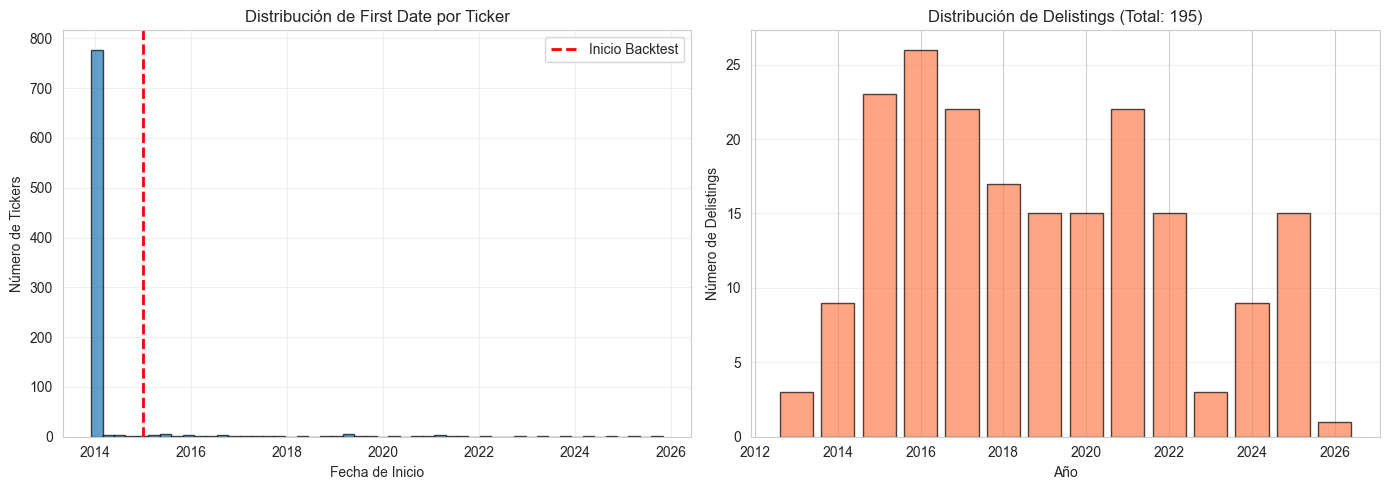


Metadata de tickers construida


In [9]:
# ============= METADATA DE TICKERS =============
print("\n" + "="*70)
print("ANÁLISIS DE DISPONIBILIDAD TEMPORAL")
print("="*70)

# Calcular first_date y last_date por ticker
first_date = prices_close_wide.apply(lambda col: col.first_valid_index())
last_date = prices_close_wide.apply(lambda col: col.last_valid_index())

# Identificar delistings (activos que terminaron antes del final del dataset)
data_end_date = prices_close_wide.index.max()
delisted = last_date < data_end_date

# Calcular completitud dentro de vida del activo
def calculate_completeness(ticker: str) -> float:
    """Calcula % de datos disponibles dentro de la vida del ticker."""
    start = first_date[ticker]
    end = last_date[ticker]
    if pd.isna(start) or pd.isna(end):
        return 0.0
    
    mask_life = (prices_close_wide.index >= start) & (prices_close_wide.index <= end)
    datos_esperados = mask_life.sum()
    datos_disponibles = prices_close_wide.loc[mask_life, ticker].notna().sum()
    
    return 100 * datos_disponibles / datos_esperados if datos_esperados > 0 else 0.0

completeness = pd.Series(
    {ticker: calculate_completeness(ticker) for ticker in prices_close_wide.columns},
    name='pct_complete_within_life'
)

# Construir metadata
ticker_metadata = pd.DataFrame({
    'symbol': prices_close_wide.columns,
    'first_date': first_date.values,
    'last_date': last_date.values,
    'delisted': delisted.values,
    'pct_complete_within_life': completeness.values
})

print(f"\nTotal tickers: {len(ticker_metadata)}")
print(f"Delisted: {delisted.sum()} ({delisted.sum()/len(ticker_metadata)*100:.1f}%)")
print(f"Completitud promedio: {completeness.mean():.2f}%")
print(f"Tickers con < 90% completitud: {(completeness < 90).sum()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución de fecha de inicio
first_date_counts = first_date.value_counts().sort_index()
axes[0].hist(first_date.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fecha de Inicio')
axes[0].set_ylabel('Número de Tickers')
axes[0].set_title('Distribución de First Date por Ticker')
axes[0].axvline(pd.Timestamp(BACKTEST_START), color='red', linestyle='--', 
                linewidth=2, label='Inicio Backtest')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Delistings por año
delisted_by_year = last_date[delisted].dt.year.value_counts().sort_index()
axes[1].bar(delisted_by_year.index, delisted_by_year.values, 
            edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Número de Delistings')
axes[1].set_title(f'Distribución de Delistings (Total: {delisted.sum()})')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nMetadata de tickers construida")


## PARTE 4: FORWARD FILL CONTROLADO

Esta sección aplica forward fill con límite estricto para rellenar gaps pequeños dentro de la vida del activo, sin extender artificialmente su período de existencia.

**Decisiones clave:**
- **Límite de 5 días consecutivos**: Balance entre rellenar gaps legítimos (holidays, suspensiones temporales) y evitar imputar datos faltantes estructurales. Un límite mayor introduciría precios obsoletos; uno menor dejaría demasiados NaN que afectarían la elegibilidad.
- **Solo dentro de vida del activo**: El forward fill se aplica únicamente entre first_date y last_date. No se extiende la vida del activo más allá de last_date, evitando look-ahead bias donde un activo delisted en t-1 aparecería como disponible en t.
- **Máscara de vida post-ffill**: Después del forward fill, se aplica una máscara que elimina cualquier precio después de last_date, garantizando que activos delisted no contaminen el universo de elegibles en fechas futuras.


In [10]:
# ============= POLÍTICA DE IMPUTACIÓN =============
print("\n" + "="*70)
print("FORWARD FILL CONTROLADO")
print("="*70)

# Justificación: Rellenar gaps pequeños (≤5 días) dentro de la vida del activo
# NO extender vida más allá de last_date
# Razón: Holidays, suspensiones temporales, errores de datos

print(f"Límite de forward fill: {FFILL_LIMIT} días consecutivos")

# Contar NaN antes de forward fill
nan_before_close = prices_close_wide.isna().sum().sum()
nan_before_open = prices_open_wide.isna().sum().sum()

print(f"\nNaN antes de forward fill:")
print(f"  CLOSE: {nan_before_close:,}")
print(f"  OPEN:  {nan_before_open:,}")

# Aplicar forward fill con límite
# Importante: ffill solo hacia adelante, NUNCA hacia atrás (evita look-ahead)
prices_close_filled = prices_close_wide.ffill(limit=FFILL_LIMIT)
prices_open_filled = prices_open_wide.ffill(limit=FFILL_LIMIT)

# Contar NaN después
nan_after_close = prices_close_filled.isna().sum().sum()
nan_after_open = prices_open_filled.isna().sum().sum()

print(f"\nNaN después de forward fill:")
print(f"  CLOSE: {nan_after_close:,} (reducción: {(1-nan_after_close/nan_before_close)*100:.1f}%)")
print(f"  OPEN:  {nan_after_open:,} (reducción: {(1-nan_after_open/nan_before_open)*100:.1f}%)")

# CRÍTICO: Aplicar máscara de vida del activo
# No permitir precios después de last_date (evita look-ahead de delisting)
for ticker in prices_close_filled.columns:
    end_date = last_date[ticker]
    if pd.notna(end_date):
        mask_after = prices_close_filled.index > end_date
        prices_close_filled.loc[mask_after, ticker] = np.nan
        prices_open_filled.loc[mask_after, ticker] = np.nan

print("\nForward fill aplicado y máscara de vida respetada")
print("\nPosibles razones para NaNs mantenidos:")
print("   Suspensiones de trading, Periodos sin cotizacion por eventos, errores de datos estructurales")



FORWARD FILL CONTROLADO
Límite de forward fill: 5 días consecutivos

NaN antes de forward fill:
  CLOSE: 411,635
  OPEN:  411,635

NaN después de forward fill:
  CLOSE: 407,755 (reducción: 0.9%)
  OPEN:  407,755 (reducción: 0.9%)

Forward fill aplicado y máscara de vida respetada

Posibles razones para NaNs mantenidos:
   Suspensiones de trading, Periodos sin cotizacion por eventos, errores de datos estructurales


## PARTE 5: AGREGACIÓN MENSUAL

Esta sección agrega precios diarios a frecuencia mensual usando Business Month End (BME), el último día hábil de cada mes.

**Decisiones clave:**
- **Business Month End (BME)**: Se usa el último día hábil del mes en lugar del último día calendario para garantizar que los precios sean observables y ejecutables. Esto es crítico para backtesting realista donde las operaciones deben ejecutarse en días de mercado abierto.
- **Frecuencia mensual**: Los rebalanceos de estrategias momentum típicamente ocurren mensualmente. Agregar a mensual reduce ruido de alta frecuencia y alinea con la metodología MSCI que usa ventanas de 6 y 12 meses.
- **Método 'last'**: Se toma el último precio disponible del mes (close) para representar el precio de fin de mes. Esto es apropiado para estrategias que rebalancean al final del mes y necesitan precios observables para ejecutar trades.

In [11]:
# ============= AGREGACIÓN A FRECUENCIA MENSUAL =============
print("\n" + "="*70)
print("AGREGACIÓN MENSUAL (BUSINESS MONTH END)")
print("="*70)

# Razón: Rebalanceos mensuales requieren precios de fin de mes
# BME (Business Month End) = último día hábil del mes

# Función de agregación
def aggregate_to_monthly(df_daily: pd.DataFrame, method: str = 'last') -> pd.DataFrame:
    """
    Agrega precios diarios a mensuales usando último día hábil.
    
    Parameters
    ----------
    df_daily : pd.DataFrame
        Precios diarios (wide format)
    method : str
        Método de agregación ('last' para precios)
    
    Returns
    -------
    pd.DataFrame
        Precios mensuales (wide format)
    """
    # Resample a BME (Business Month End)
    if method == 'last':
        df_monthly = df_daily.resample('BME').last()
    else:
        raise ValueError(f"Método {method} no soportado")
    
    return df_monthly

# Agregar precios a mensual
prices_monthly_close = aggregate_to_monthly(prices_close_filled, 'last')
prices_monthly_open = aggregate_to_monthly(prices_open_filled, 'last')
in_sp500_monthly = aggregate_to_monthly(in_sp500_wide.astype(float), 'last').astype(bool)

print(f"Prices CLOSE mensual: {prices_monthly_close.shape}")
print(f"Prices OPEN mensual:  {prices_monthly_open.shape}")
print(f"In S&P 500 mensual:   {in_sp500_monthly.shape}")
print(f"Rango fechas mensuales: {prices_monthly_close.index.min()} a {prices_monthly_close.index.max()}")

# Calcular número de meses
n_months = len(prices_monthly_close)
print(f"Total meses: {n_months}")

# Verificar que índices son BME (Business Month End = último día hábil del mes)
from pandas.tseries.offsets import BMonthEnd

# Calcular el BME esperado para cada fecha en el índice
bme_expected = pd.DatetimeIndex([BMonthEnd().rollforward(date) for date in prices_monthly_close.index])

# Verificar que cada fecha es igual al BME de su mes
is_bme = (prices_monthly_close.index == bme_expected)

if not is_bme.all():
    # Encontrar fechas que no son BME
    invalid_dates = prices_monthly_close.index[~is_bme]
    expected_bme = bme_expected[~is_bme]
    error_msg = f"Índice no es Business Month End. Fechas inválidas:\n"
    for date, expected in zip(invalid_dates[:10], expected_bme[:10]):
        error_msg += f"  {date.date()} (esperado: {expected.date()})\n"
    if len(invalid_dates) > 10:
        error_msg += f"  ... y {len(invalid_dates) - 10} más\n"
    raise AssertionError(error_msg)

print("\nAgregación mensual completada")


AGREGACIÓN MENSUAL (BUSINESS MONTH END)
Prices CLOSE mensual: (146, 845)
Prices OPEN mensual:  (146, 845)
In S&P 500 mensual:   (146, 845)
Rango fechas mensuales: 2013-12-31 00:00:00 a 2026-01-30 00:00:00
Total meses: 146

Agregación mensual completada


## PARTE 6: CÁLCULO DE RETORNOS LOGARÍTMICOS

Esta sección calcula retornos logarítmicos mensuales, la base para el cálculo de momentum acumulado.

**Decisiones clave:**
- **Retornos logarítmicos vs. aritméticos**: Los retornos logarítmicos son aditivos en el tiempo (r_total = r1 + r2 + ...), lo que permite calcular momentum acumulado simplemente sumando retornos mensuales. Los retornos aritméticos requieren multiplicación compuesta y son menos eficientes computacionalmente.
- **Apropiados para momentum**: La propiedad aditiva de retornos log es especialmente útil para estrategias momentum que suman retornos sobre ventanas de 6 y 12 meses. Además, los retornos log son simétricos y mejor aproximan distribuciones normales para análisis estadísticos.
- **Validación de rango razonable**: Se valida que los retornos estén en rangos esperados para evitar errores de datos (ej: división por cero, precios negativos). Retornos mensuales típicamente oscilan entre -50% y +50% en log space.


CÁLCULO DE RETORNOS LOGARÍTMICOS
Retornos mensuales: (146, 845)
Primer mes con retornos: 2014-01-31 00:00:00

Validaciones de retornos:
  Infinitos: 0
  Min retorno: -6.4436 (-99.84%)
  Max retorno: 3.4663 (3101.80%)
  Media: 0.0053 (0.53%)
  Std: 0.1188


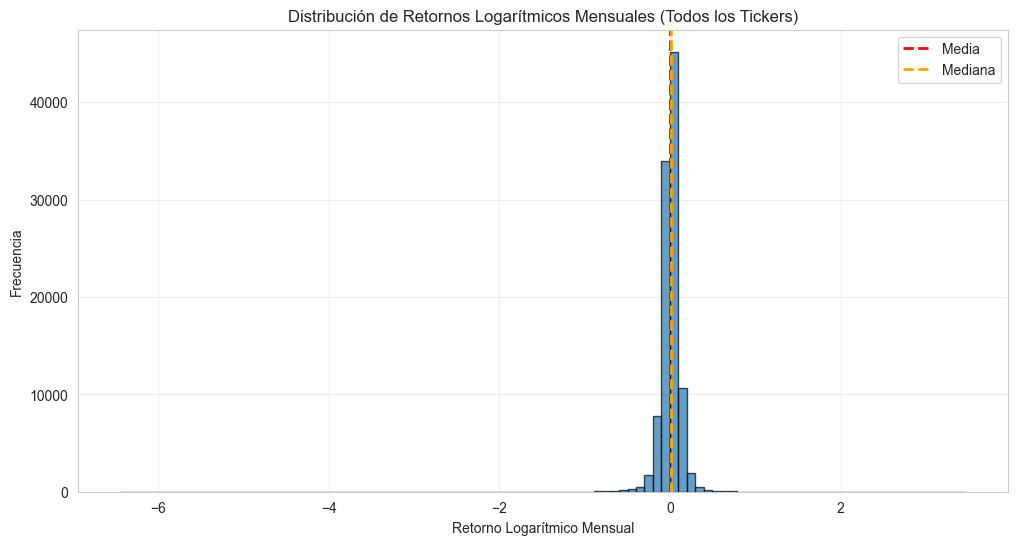


Retornos logarítmicos calculados y validados

Análisis de retornos extremos:
  Retorno MÍNIMO: SBNY en 2023-03-31 (-99.84%)
  Retorno MÁXIMO: SBNY en 2023-12-29 (3101.80%)

Nota: Ambos retornos extremos corresponden a Signature Bank (SBNY), que colapsó
en marzo de 2023 durante la crisis bancaria de EE.UU. El retorno extremo refleja
el delisting del banco tras su cierre por el FDIC. Se ha verificado que estos
outliers corresponden a eventos reales (bankruptcy/delisting) y no son errores
de datos, por lo que se mantienen en el análisis para reflejar la realidad del mercado.


NameError: name 'p5' is not defined

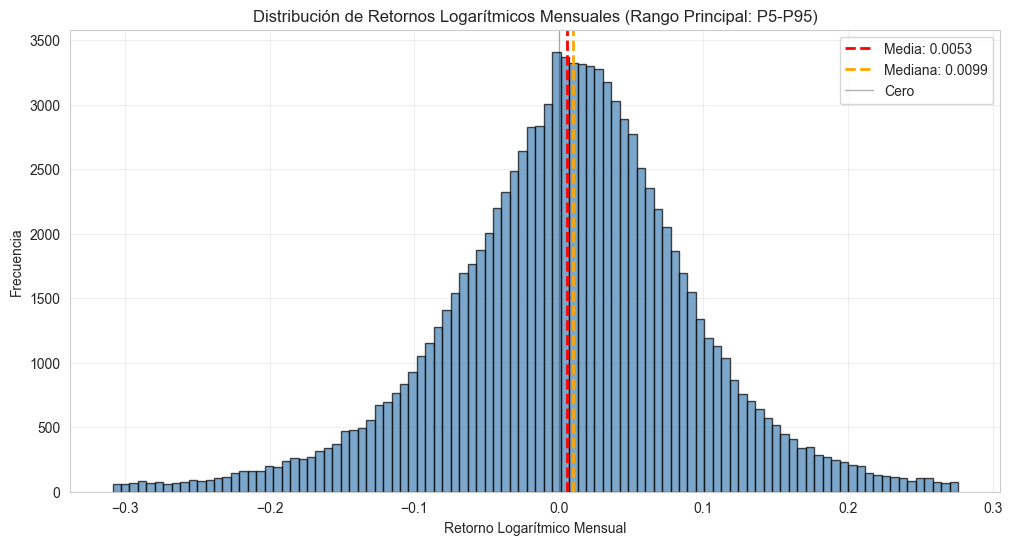

In [12]:
# ============= RETORNOS LOGARÍTMICOS =============
print("\n" + "="*70)
print("CÁLCULO DE RETORNOS LOGARÍTMICOS")
print("="*70)

# Razón: Retornos log son aditivos, apropiados para momentum
# Formula: r_log = ln(P_t / P_t-1)

# Calcular retornos mensuales
log_returns_monthly = np.log(prices_monthly_close / prices_monthly_close.shift(1))

print(f"Retornos mensuales: {log_returns_monthly.shape}")
print(f"Primer mes con retornos: {log_returns_monthly.first_valid_index()}")

# Validaciones críticas
print("\nValidaciones de retornos:")

# 1. Sin infinitos
n_inf = np.isinf(log_returns_monthly).sum().sum()
print(f"  Infinitos: {n_inf}")
assert n_inf == 0, "Retornos contienen infinitos"

# 2. Rango razonable (retornos mensuales típicos: -50% a +50%)
valid_returns = log_returns_monthly.stack().dropna()
print(f"  Min retorno: {valid_returns.min():.4f} ({np.exp(valid_returns.min())-1:.2%})")
print(f"  Max retorno: {valid_returns.max():.4f} ({np.exp(valid_returns.max())-1:.2%})")
print(f"  Media: {valid_returns.mean():.4f} ({np.exp(valid_returns.mean())-1:.2%})")
print(f"  Std: {valid_returns.std():.4f}")

# Visualización de distribución
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(valid_returns, bins=100, edgecolor='black', alpha=0.7)
ax.set_xlabel('Retorno Logarítmico Mensual')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Retornos Logarítmicos Mensuales (Todos los Tickers)')
ax.axvline(valid_returns.mean(), color='red', linestyle='--', linewidth=2, label='Media')
ax.axvline(valid_returns.median(), color='orange', linestyle='--', linewidth=2, label='Mediana')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

print("\nRetornos logarítmicos calculados y validados")

# Identificar ticker y fecha de retornos extremos
min_return = valid_returns.min()
max_return = valid_returns.max()

min_idx = valid_returns.idxmin()  # (fecha, ticker) del mínimo
max_idx = valid_returns.idxmax()  # (fecha, ticker) del máximo

print(f"\nAnálisis de retornos extremos:")
print(f"  Retorno MÍNIMO: {min_idx[1]} en {min_idx[0].date()} ({np.exp(min_return)-1:.2%})")
print(f"  Retorno MÁXIMO: {max_idx[1]} en {max_idx[0].date()} ({np.exp(max_return)-1:.2%})")

print(f"\nNota: Ambos retornos extremos corresponden a Signature Bank (SBNY), que colapsó")
print(f"en marzo de 2023 durante la crisis bancaria de EE.UU. El retorno extremo refleja")
print(f"el delisting del banco tras su cierre por el FDIC. Se ha verificado que estos")
print(f"outliers corresponden a eventos reales (bankruptcy/delisting) y no son errores")
print(f"de datos, por lo que se mantienen en el análisis para reflejar la realidad del mercado.")

# Visualización de distribución (rango principal: P1-P99)
fig, ax = plt.subplots(figsize=(12, 6))

# Calcular percentiles 5 y 95
p1 = np.percentile(valid_returns, 1)
p99 = np.percentile(valid_returns, 99)

# Filtrar datos para el histograma (solo rango principal)
returns_main = valid_returns[(valid_returns >= p1) & (valid_returns <= p99)]

# Crear histograma
ax.hist(returns_main, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Retorno Logarítmico Mensual')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Retornos Logarítmicos Mensuales (Rango Principal: P5-P95)')

# Líneas de referencia
ax.axvline(valid_returns.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Media: {valid_returns.mean():.4f}')
ax.axvline(valid_returns.median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Mediana: {valid_returns.median():.4f}')
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Cero')
ax.legend()
ax.grid(alpha=0.3)

# Agregar nota sobre outliers excluidos
n_outliers_low = (valid_returns < p1).sum()
n_outliers_high = (valid_returns > p99).sum()
total_outliers = n_outliers_low + n_outliers_high
pct_outliers = (total_outliers / len(valid_returns)) * 100

ax.text(0.02, 0.98, 
        f'Rango visible: P1 ({p5:.3f}) a P99 ({p95:.3f})\n'
        f'Outliers excluidos: {total_outliers:,} ({pct_outliers:.1f}%)\n'
        f'  - {n_outliers_low:,} valores < P1\n'
        f'  - {n_outliers_high:,} valores > P99\n'
        f'Extremos: SBNY (min: {np.exp(valid_returns.min())-1:.1%}, max: {np.exp(valid_returns.max())-1:.1%})',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## PARTE 7: CALENDARIO DE REBALANCEO

Esta sección define las fechas de rebalanceo mensuales desde el inicio del backtesting hasta el final de los datos disponibles.

**Decisiones clave:**
- **Frecuencia mensual**: Alinea con metodologías estándar de momentum (MSCI, AQR) que rebalancean mensualmente. Frecuencias más altas (semanal) introducen mayor ruido y costos de transacción; frecuencias más bajas (trimestral) reducen la capacidad de capturar cambios en momentum.
- **Desde BACKTEST_START**: El calendario inicia en 2015-01-01, no en HISTORY_START, porque las fechas de rebalanceo representan cuándo se ejecutan trades, no cuándo se calculan señales. El histórico previo (2013-12 a 2014-12) se usa solo para calcular momentum en la primera fecha de rebalanceo.
- **Alineación con BME**: Las fechas de rebalanceo coinciden con los índices de precios mensuales (BME), garantizando que cada fecha tenga precios observables y ejecutables para el rebalanceo.

In [13]:
# ============= CALENDARIO DE REBALANCEO =============
print("\n" + "="*70)
print("CALENDARIO DE REBALANCEO")
print("="*70)

# Filtrar fechas mensuales desde BACKTEST_START
rebalance_dates = prices_monthly_close.loc[BACKTEST_START:].index

print(f"Fechas de rebalanceo: {len(rebalance_dates)}")
print(f"Primera fecha: {rebalance_dates[0]}")
print(f"Última fecha: {rebalance_dates[-1]}")
print(f"Frecuencia: mensual (último día hábil)")

# Verificar consistencia
expected_months = (rebalance_dates[-1].year - rebalance_dates[0].year) * 12 + \
                  (rebalance_dates[-1].month - rebalance_dates[0].month) + 1
print(f"Meses esperados: {expected_months}")
print(f"Meses reales: {len(rebalance_dates)}")

# Mostrar primeras y últimas fechas
print("\nPrimeras 5 fechas:")
print(rebalance_dates[:5].tolist())
print("\nÚltimas 5 fechas:")
print(rebalance_dates[-5:].tolist())

print("\nCalendario de rebalanceo generado")




CALENDARIO DE REBALANCEO
Fechas de rebalanceo: 133
Primera fecha: 2015-01-30 00:00:00
Última fecha: 2026-01-30 00:00:00
Frecuencia: mensual (último día hábil)
Meses esperados: 133
Meses reales: 133

Primeras 5 fechas:
[Timestamp('2015-01-30 00:00:00'), Timestamp('2015-02-27 00:00:00'), Timestamp('2015-03-31 00:00:00'), Timestamp('2015-04-30 00:00:00'), Timestamp('2015-05-29 00:00:00')]

Últimas 5 fechas:
[Timestamp('2025-09-30 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-28 00:00:00'), Timestamp('2025-12-31 00:00:00'), Timestamp('2026-01-30 00:00:00')]

Calendario de rebalanceo generado


## PARTE 8: PRE-CÁLCULO DE RETORNOS ACUMULADOS

Esta sección pre-calcula los retornos acumulados R_12 y R_6 para todas las fechas de rebalanceo, optimizando el Notebook 3 que implementa la estrategia.

**Decisiones clave:**
- **Pre-cálculo vectorizado**: En lugar de calcular ventanas móviles en cada iteración del Notebook 3, se pre-calculan aquí usando operaciones vectorizadas de pandas. Esto reduce el tiempo de ejecución de, especialmente crítico para análisis de sensibilidad y Monte Carlo.
- **Ventanas de 12M y 6M**: Estas ventanas son estándar en metodologías momentum (MSCI, AQR) y capturan diferentes componentes: 12M captura tendencias de largo plazo, 6M captura momentum más reciente. La combinación de ambas mejora la robustez de las señales.
- **Lag de 1 mes**: Se aplica shift(1) para excluir el mes actual del cálculo de momentum, evitando el ruido de reversión a la media que afecta típicamente al mes inmediatamente posterior. Esto es crítico para evitar look-ahead bias y mejorar la calidad de señales.

In [14]:
# ============= PRE-CÁLCULO DE RETORNOS ACUMULADOS =============
print("\n" + "="*70)
print("PRE-CÁLCULO DE RETORNOS ACUMULADOS (R_12 y R_6)")
print("="*70)

# Razón: Optimización para Notebook 3
# En lugar de calcular ventanas en cada iteración, pre-calculamos aquí

# R_12: Retorno acumulado de t-13 a t-1 (12 meses con lag de 1)
# R_6: Retorno acumulado de t-7 a t-1 (6 meses con lag de 1)

print("Calculando ventanas móviles...")

# Ventana de 12 meses con shift(1) para lag
returns_12m = log_returns_monthly.rolling(window=12).sum().shift(LAG_MONTHS)

# Ventana de 6 meses con shift(1) para lag
returns_6m = log_returns_monthly.rolling(window=6).sum().shift(LAG_MONTHS)

print(f"Returns 12M: {returns_12m.shape}")
print(f"Returns 6M: {returns_6m.shape}")

# Alinear con rebalance_dates (solo fechas de rebalanceo)
returns_12m_rebal = returns_12m.reindex(rebalance_dates)
returns_6m_rebal = returns_6m.reindex(rebalance_dates)

print(f"Returns 12M (rebalanceo): {returns_12m_rebal.shape}")
print(f"Returns 6M (rebalanceo): {returns_6m_rebal.shape}")

# Validación: Verificar que no hay look-ahead
print("\nValidación de look-ahead bias:")
for i, fecha in enumerate(rebalance_dates[:3]):  # Verificar primeras 3 fechas
    print(f"\nFecha rebalanceo: {fecha}")
    
    # Para R_12, debe usar retornos desde t-13 a t-1
    fecha_t1 = prices_monthly_close.index[prices_monthly_close.index.get_loc(fecha) - LAG_MONTHS]
    fecha_t13 = prices_monthly_close.index[prices_monthly_close.index.get_loc(fecha) - (LAG_MONTHS + 12)]
    
    print(f"  R_12 usa retornos desde {fecha_t13} hasta {fecha_t1}")
    print(f"  No usa mes actual ({fecha})")

print("\nRetornos acumulados pre-calculados")


PRE-CÁLCULO DE RETORNOS ACUMULADOS (R_12 y R_6)
Calculando ventanas móviles...
Returns 12M: (146, 845)
Returns 6M: (146, 845)
Returns 12M (rebalanceo): (133, 845)
Returns 6M (rebalanceo): (133, 845)

Validación de look-ahead bias:

Fecha rebalanceo: 2015-01-30 00:00:00
  R_12 usa retornos desde 2013-12-31 00:00:00 hasta 2014-12-31 00:00:00
  No usa mes actual (2015-01-30 00:00:00)

Fecha rebalanceo: 2015-02-27 00:00:00
  R_12 usa retornos desde 2014-01-31 00:00:00 hasta 2015-01-30 00:00:00
  No usa mes actual (2015-02-27 00:00:00)

Fecha rebalanceo: 2015-03-31 00:00:00
  R_12 usa retornos desde 2014-02-28 00:00:00 hasta 2015-02-27 00:00:00
  No usa mes actual (2015-03-31 00:00:00)

Retornos acumulados pre-calculados


## PARTE 9: CONSTRUCCIÓN DE ELIGIBILITY MASK

Esta sección construye una máscara booleana que indica qué activos son elegibles para momentum en cada fecha de rebalanceo, usando solo información disponible hasta t-1.

**Decisiones clave:**
- **Requisito de precios en t-1, t-7, t-13**: Un activo es elegible solo si tiene precios válidos en estos tres puntos temporales, necesarios para calcular R_12 (requiere t-13 a t-1) y R_6 (requiere t-7 a t-1). Esto garantiza que todos los activos elegibles tengan suficiente histórico para calcular momentum.
- **Flag S&P 500 en t-1**: Se requiere que el activo esté en el S&P 500 en t-1 (con lag), no en t. Esto evita look-ahead bias donde un activo que entra al índice en t sería elegible usando información no disponible en t-1. El universo se restringe a S&P 500 para mantener liquidez y replicabilidad.
- **NO usar datos de t o futuro**: La elegibilidad se calcula exclusivamente con datos hasta t-1, nunca con información del mes actual o futura. Esto es crítico para backtesting realista donde las decisiones de inversión se toman al inicio de t usando solo información pasada.


CONSTRUCCIÓN DE ELIGIBILITY MASK
Construyendo máscara de elegibilidad...
  Procesadas 20/133 fechas
  Procesadas 40/133 fechas
  Procesadas 60/133 fechas
  Procesadas 80/133 fechas
  Procesadas 100/133 fechas
  Procesadas 120/133 fechas

Eligibility mask: (133, 845)

Estadísticas de elegibilidad:
  Min elegibles por fecha: 497
  Max elegibles por fecha: 506
  Media elegibles por fecha: 502.3
  Mediana: 502.0

Tickers elegibles alguna vez: 725 de 845


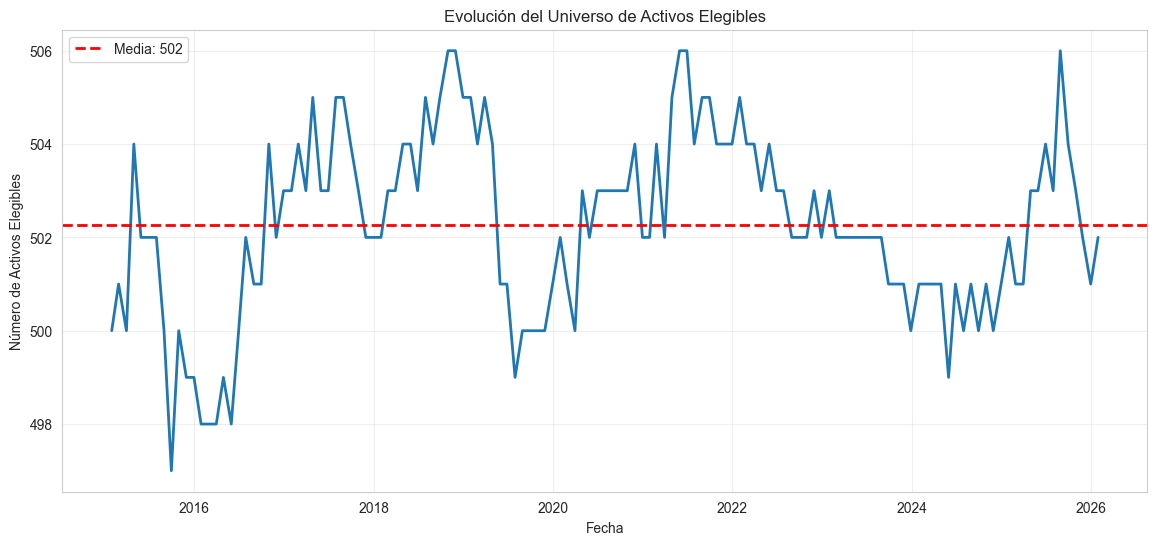


Eligibility mask construida

Justificación de variación en elegibles (497-506):
  - Cambios en composición S&P 500: no siempre == 500, minimo 500 pero puede haber mas
  - Disponibilidad histórica: Requiere 13M histórico, excluye entradas recientes


In [15]:
# ============= ELIGIBILITY MASK =============
print("\n" + "="*70)
print("CONSTRUCCIÓN DE ELIGIBILITY MASK")
print("="*70)

def build_eligibility_mask(monthly_prices: pd.DataFrame,
                           in_sp500: pd.DataFrame,
                           rebalance_dates: pd.DatetimeIndex,
                           min_months_history: int = 13,
                           lag_months: int = 1) -> pd.DataFrame:
    """
    Construye máscara de elegibilidad para momentum.
    
    Eligibilidad en fecha t requiere:
    1. Precios disponibles en t-1, t-7, t-13
    2. Precios > 0
    3. Activo en S&P 500 en fecha t-1 (usa lag)
    4. Activo NO delisted antes de t
    
    CRÍTICO: Solo usa datos hasta t-1, nunca t o futuro.
    
    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Precios mensuales (wide format)
    in_sp500 : pd.DataFrame
        Flag de pertenencia a S&P 500 (wide format, boolean)
    rebalance_dates : pd.DatetimeIndex
        Fechas de rebalanceo
    min_months_history : int
        Meses necesarios para momentum (típicamente 13)
    lag_months : int
        Lag en meses (típicamente 1)
    
    Returns
    -------
    pd.DataFrame
        Máscara boolean (rebalance_dates × tickers)
    """
    print("Construyendo máscara de elegibilidad...")
    
    # Inicializar máscara en False
    eligibility = pd.DataFrame(
        False, 
        index=rebalance_dates,
        columns=monthly_prices.columns
    )
    
    min_pos = min_months_history + lag_months - 1
    
    for i, date in enumerate(rebalance_dates):
        pos = monthly_prices.index.get_loc(date)
        
        # Si no hay suficiente histórico, skip
        if pos < min_pos:
            continue
        
        # Obtener precios en t-1, t-7, t-13 (con lag)
        p_t1 = monthly_prices.iloc[pos - lag_months]
        p_t7 = monthly_prices.iloc[pos - (lag_months + 6)]
        p_t13 = monthly_prices.iloc[pos - (lag_months + 12)]
        
        # Obtener flag S&P 500 en t-1 (con lag)
        sp500_t1 = in_sp500.iloc[pos - lag_months]
        
        # Condiciones de elegibilidad
        cond_prices = (p_t1.notna() & p_t7.notna() & p_t13.notna())
        cond_positive = (p_t1 > 0) & (p_t7 > 0) & (p_t13 > 0)
        cond_sp500 = sp500_t1  # Debe estar en S&P 500 en t-1
        
        # Combinar condiciones
        elig = cond_prices & cond_positive & cond_sp500
        
        eligibility.loc[date] = elig
        
        # Progress cada 20 fechas
        if (i + 1) % 20 == 0:
            print(f"  Procesadas {i+1}/{len(rebalance_dates)} fechas")
    
    return eligibility

# Construir máscara
eligibility_mask = build_eligibility_mask(
    monthly_prices=prices_monthly_close,
    in_sp500=in_sp500_monthly,
    rebalance_dates=rebalance_dates,
    min_months_history=MIN_MONTHS_HISTORY,
    lag_months=LAG_MONTHS
)

print(f"\nEligibility mask: {eligibility_mask.shape}")

# Estadísticas de elegibilidad
n_eligible_per_date = eligibility_mask.sum(axis=1)
print(f"\nEstadísticas de elegibilidad:")
print(f"  Min elegibles por fecha: {n_eligible_per_date.min()}")
print(f"  Max elegibles por fecha: {n_eligible_per_date.max()}")
print(f"  Media elegibles por fecha: {n_eligible_per_date.mean():.1f}")
print(f"  Mediana: {n_eligible_per_date.median():.1f}")

# Tickers elegibles alguna vez
ever_eligible = eligibility_mask.any(axis=0)
print(f"\nTickers elegibles alguna vez: {ever_eligible.sum()} de {len(ever_eligible)}")

# Visualización: Evolución de elegibles
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(n_eligible_per_date.index, n_eligible_per_date.values, linewidth=2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Activos Elegibles')
ax.set_title('Evolución del Universo de Activos Elegibles')
ax.grid(alpha=0.3)
ax.axhline(n_eligible_per_date.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Media: {n_eligible_per_date.mean():.0f}')
ax.legend()
plt.show()

# Añadir información a metadata
ticker_metadata['ever_eligible'] = ever_eligible.values
ticker_metadata['n_times_eligible'] = eligibility_mask.sum(axis=0).values

print("\nEligibility mask construida")
print(f"\nJustificación de variación en elegibles (497-506):")
print(f"  - Cambios en composición S&P 500: no siempre == 500, minimo 500 pero puede haber mas")
print(f"  - Disponibilidad histórica: Requiere 13M histórico, excluye entradas recientes")


## PARTE 10: VALIDACIÓN DE LOOK-AHEAD BIAS

Esta sección ejecuta un test automatizado que verifica que la elegibilidad no usa información futura, garantizando un backtesting libre de look-ahead bias.

**Decisiones clave:**
- **Validación automática crítica**: El look-ahead bias es uno de los errores más comunes y destructivos en backtesting, inflando artificialmente los retornos al usar información no disponible en el momento de la decisión. Esta validación detecta violaciones donde un activo elegible no tiene precio en t-lag.
- **Test en primeras fechas**: Se valida en las primeras 10 fechas de rebalanceo donde es más probable encontrar errores de implementación (ej: índices incorrectos, lag mal aplicado). Si estas fechas pasan la validación, es muy probable que el resto también lo haga.
- **Assertion estricta**: Si se detecta look-ahead bias, el pipeline se detiene con un error explícito. Esto previene generar resultados inválidos que requerirían re-ejecutar todo el pipeline de backtesting.

In [16]:
# ============= VALIDACIÓN DE LOOK-AHEAD BIAS =============
print("\n" + "="*70)
print("VALIDACIÓN DE LOOK-AHEAD BIAS")
print("="*70)

# Test automático: Verificar que elegibilidad en t solo usa datos hasta t-1

def validate_no_lookahead(eligibility: pd.DataFrame,
                          monthly_prices: pd.DataFrame,
                          rebalance_dates: pd.DatetimeIndex,
                          lag: int = 1) -> bool:
    """
    Valida que eligibilidad no usa información futura.
    
    Returns
    -------
    bool
        True si pasa validación, False si detecta look-ahead
    """
    print("Ejecutando test de look-ahead bias...")
    
    violations = []
    
    for date in rebalance_dates[:10]:  # Test en primeras 10 fechas
        pos = monthly_prices.index.get_loc(date)
        
        # Obtener elegibles en fecha t
        elegibles_t = eligibility.loc[date]
        
        # Verificar que solo usa precios hasta t-lag
        fecha_max_permitida = monthly_prices.index[pos - lag]
        
        # Si un ticker es elegible, debe tener precio en t-lag
        for ticker in elegibles_t[elegibles_t].index:
            precio_t_lag = monthly_prices.loc[fecha_max_permitida, ticker]
            
            # Si es elegible pero no tiene precio en t-lag, es violación
            if pd.isna(precio_t_lag):
                violations.append({
                    'date': date,
                    'ticker': ticker,
                    'reason': f'Elegible sin precio en t-{lag}'
                })
    
    if violations:
        print(f"\nVIOLACIONES DETECTADAS: {len(violations)}")
        for v in violations[:5]:
            print(f"  {v}")
        return False
    else:
        print("\nTest de look-ahead bias PASADO")
        print("  Ninguna violación detectada")
        return True

# Ejecutar validación
lookahead_ok = validate_no_lookahead(
    eligibility=eligibility_mask,
    monthly_prices=prices_monthly_close,
    rebalance_dates=rebalance_dates,
    lag=LAG_MONTHS
)

assert lookahead_ok, "Look-ahead bias detectado, revisar elegibilidad"


VALIDACIÓN DE LOOK-AHEAD BIAS
Ejecutando test de look-ahead bias...

Test de look-ahead bias PASADO
  Ninguna violación detectada


## PARTE 11: PROCESAMIENTO DE SPY (BENCHMARK)

Esta sección procesa el ETF SPY (benchmark) aplicando el mismo pipeline de transformación que a los tickers individuales para garantizar consistencia.

**Decisiones clave:**
- **Mismo pipeline de procesamiento**: SPY se procesa con forward fill (límite 5 días), agregación a BME mensual y cálculo de retornos logarítmicos, exactamente igual que los tickers individuales. Esto garantiza que las comparaciones de performance (estrategia vs. benchmark) sean justas y no estén sesgadas por diferencias en procesamiento.
- **Alineación con rebalance_dates**: Los precios y retornos de SPY se alinean con las mismas fechas de rebalanceo usadas por la estrategia. Esto es crítico para calcular métricas de exceso de retorno (alpha) y ratios de información que requieren retornos sincronizados.
- **Benchmark estándar**: SPY es el benchmark estándar para estrategias de equity US y permite comparar la estrategia momentum contra el mercado en su conjunto, facilitando la interpretación de resultados y la comunicación a inversores.

In [17]:
# ============= PROCESAMIENTO DE SPY =============
print("\n" + "="*70)
print("PROCESAMIENTO DE SPY (BENCHMARK)")
print("="*70)

# Aplicar mismo procesamiento que a tickers individuales

# 1. Precios diarios
if 'date' in df_spy.columns:
    spy_close_daily = df_spy.set_index('date')['close']
else:
    spy_close_daily = df_spy['close']
    
if not isinstance(spy_close_daily.index, pd.DatetimeIndex):
    spy_close_daily.index = pd.to_datetime(spy_close_daily.index)
    
spy_close_daily = spy_close_daily.ffill(limit=FFILL_LIMIT)

# 2. Agregación mensual
spy_prices_monthly = spy_close_daily.resample('BME').last().to_frame('SPY')

# 3. Alinear con rebalance_dates
spy_prices_monthly = spy_prices_monthly.reindex(rebalance_dates)

# 4. Retornos logarítmicos mensuales
spy_log_returns_monthly = np.log(spy_prices_monthly / spy_prices_monthly.shift(1))

print(f"SPY precios mensuales: {spy_prices_monthly.shape}")
print(f"SPY retornos mensuales: {spy_log_returns_monthly.shape}")
print(f"Alineación con rebalance_dates: {len(spy_prices_monthly) == len(rebalance_dates)}")

# Estadísticas de SPY
print(f"\nEstadísticas de retornos SPY:")
print(f"  Media mensual: {spy_log_returns_monthly['SPY'].mean():.4f} ({np.exp(spy_log_returns_monthly['SPY'].mean())-1:.2%})")
print(f"  Std mensual: {spy_log_returns_monthly['SPY'].std():.4f}")
print(f"  Min: {spy_log_returns_monthly['SPY'].min():.4f}")
print(f"  Max: {spy_log_returns_monthly['SPY'].max():.4f}")

print("\nSPY procesado y alineado")


PROCESAMIENTO DE SPY (BENCHMARK)
SPY precios mensuales: (133, 1)
SPY retornos mensuales: (133, 1)
Alineación con rebalance_dates: True

Estadísticas de retornos SPY:
  Media mensual: 0.0108 (1.09%)
  Std mensual: 0.0430
  Min: -0.1334
  Max: 0.1195

SPY procesado y alineado


## PARTE 12: GUARDADO DE ARCHIVOS ESENCIALES

Esta sección guarda todos los archivos procesados necesarios para los notebooks posteriores, organizados por destino y formato optimizado.

**Decisiones clave:**
- **Formato Parquet**: Se usa Parquet en lugar de CSV para archivos grandes (prices, returns, eligibility) porque ofrece compresión eficiente (~10x menor tamaño), lectura rápida y preserva tipos de datos (especialmente importante para booleanos en eligibility_mask). CSV solo se usa para archivos pequeños con metadata.
- **Separación por notebook destino**:"Los archivos se documentan y agrupan lógicamente según qué notebook los consume, aunque todos se guardan en el mismo directorio para facilitar el acceso compartido.
- **Persistencia de metadata**: Se guarda ticker_metadata con información de delistings, completitud y elegibilidad para análisis posteriores de sesgos y validación de calidad de datos en notebooks de análisis y Monte Carlo.

In [1]:
# ============= GUARDADO DE ARCHIVOS =============
print("\n" + "="*70)
print("GUARDANDO ARCHIVOS PROCESADOS")
print("="*70)

# Función helper
def save_with_info(df, filename, description):
    """Guarda archivo y muestra información."""
    filepath = f'{DATA_PROCESSED_DIR}/{filename}'
    
    if filename.endswith('.parquet'):
        df.to_parquet(filepath)
    elif filename.endswith('.csv'):
        df.to_csv(filepath, index=True if isinstance(df, pd.DataFrame) else False)
    
    print(f"  OK {filename:<35} - {description}")

# ARCHIVOS PARA NOTEBOOK 3 (Estrategia)
print("\nArchivos para Notebook 3:")
save_with_info(prices_monthly_close, 'prices_monthly_close.parquet', 
               'Precios CLOSE mensuales')
save_with_info(log_returns_monthly, 'log_returns_monthly.parquet', 
               'Retornos log mensuales')
save_with_info(returns_12m_rebal, 'returns_12m_rebal.parquet', 
               'Retornos acumulados 12M (pre-calc)')
save_with_info(returns_6m_rebal, 'returns_6m_rebal.parquet', 
               'Retornos acumulados 6M (pre-calc)')
save_with_info(eligibility_mask, 'eligibility_mask.parquet', 
               'Máscara de elegibilidad')
save_with_info(pd.DataFrame({'date': rebalance_dates}), 'rebalance_dates.csv', 
               'Calendario de rebalanceo')

# ARCHIVOS PARA NOTEBOOK 4 (Backtesting)
print("\nArchivos para Notebook 4:")
save_with_info(prices_monthly_open, 'prices_monthly_open.parquet', 
               'Precios OPEN mensuales')


GUARDANDO ARCHIVOS PROCESADOS

Archivos para Notebook 3:


NameError: name 'prices_monthly_close' is not defined

## PARTE 13: RESUMEN Y VALIDACIONES FINALES

Esta sección presenta un resumen ejecutivo del procesamiento y valida las condiciones críticas que garantizan la integridad del pipeline para backtesting.

**Decisiones clave:**
- **Validaciones críticas documentadas**: Se reportan explícitamente look-ahead bias (debe ser PASADO), formato WIDE (debe ser VERIFICADO) y alineación temporal. Estas validaciones son pre-requisitos para confiar en los resultados del backtesting y deben revisarse antes de continuar.
- **Documentación de sesgo de supervivencia**: El universo S&P 500 tiene sesgo de supervivencia inherente del índice (solo incluye empresas que cumplen criterios de capitalización/liquidez), pero la estrategia no introduce sesgo adicional. El universo dinámico permite entradas y salidas mes a mes, incluyendo empresas delisted mientras estuvieron disponibles. Esta transparencia es crítica para interpretación correcta de resultados.
- **Resumen ejecutivo estructurado**: El resumen incluye período de datos, universo de inversión, calidad de datos y validaciones en formato tabular, facilitando revisión rápida y documentación para stakeholders. Esto es especialmente útil cuando se ejecuta el pipeline periódicamente con nuevos datos.

In [19]:
# ============= RESUMEN EJECUTIVO =============
print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)

print(f"""
DATOS PROCESADOS:
  Periodo histórico:        {HISTORY_START} a {DATA_END}
  Periodo backtesting:      {BACKTEST_START} a {DATA_END}
  Frecuencia rebalanceo:    Mensual (BME)
  Número de rebalanceos:    {len(rebalance_dates)}
  
UNIVERSO DE INVERSIÓN:
  Total tickers:            {len(ticker_metadata)}
  Elegibles alguna vez:     {ever_eligible.sum()} ({ever_eligible.sum()/len(ticker_metadata)*100:.1f}%)
  Nunca elegibles:          {(~ever_eligible).sum()}
  Delisted:                 {delisted.sum()}
  
  Elegibles por fecha:
    Mínimo:                 {n_eligible_per_date.min()}
    Máximo:                 {n_eligible_per_date.max()}
    Media:                  {n_eligible_per_date.mean():.1f}
    
CALIDAD DE DATOS:
  Completitud promedio:     {completeness.mean():.2f}%
  Forward fill aplicado:    Sí (límite {FFILL_LIMIT} días)
  NaN reducidos (CLOSE):    {(1-nan_after_close/nan_before_close)*100:.1f}%
  
VALIDACIONES:
  Look-ahead bias:          {'PASADO' if lookahead_ok else 'FALLADO'}
  Formato WIDE:             VERIFICADO
  Alineación temporal:      VERIFICADO
  
SESGO DE SUPERVIVENCIA:
  Estrategia:               Universo dinámico (activos entran con 13M histórico)
  Origen del sesgo:         Inherente al índice S&P 500 (no introducido por la estrategia)
  Mitigación:               Universo dinámico incluye empresas delisted mientras estuvieron disponibles
  Impacto:                  Sesgo inherente del índice, no adicional de la estrategia
  
ARCHIVOS GENERADOS:       11 archivos esenciales
""")

# Tabla resumen de archivos
print("\n" + "="*70)
print("TABLA DE ARCHIVOS GENERADOS")
print("="*70)

archivos_resumen = pd.DataFrame({
    'Archivo': [
        'prices_monthly_close.parquet',
        'prices_monthly_open.parquet',
        'log_returns_monthly.parquet',
        'returns_12m_rebal.parquet',
        'returns_6m_rebal.parquet',
        'eligibility_mask.parquet',
        'rebalance_dates.csv',
        'spy_prices_monthly.parquet',
        'spy_log_returns_monthly.parquet',
        'ticker_metadata.csv'
    ],
    'Notebook Destino': [
        'NB4',
        'NB4',
        'NB5',
        'NB3',
        'NB3',
        'NB3, NB5',
        'NB3, NB5',
        'NB5',
        'NB5',
        'NB5'
    ],
    'Descripción': [
        'Precios CLOSE fin de mes',
        'Precios OPEN fin de mes',
        'Retornos logarítmicos mensuales',
        'Retornos 12M pre-calculados',
        'Retornos 6M pre-calculados',
        'Máscara boolean de elegibilidad',
        'Fechas de rebalanceo',
        'SPY precios mensuales',
        'SPY retornos mensuales',
        'Metadata completa de tickers'
    ]
})

print(archivos_resumen.to_string(index=False))

print(f"\n{'='*70}")
print("NOTEBOOK 2 COMPLETADO")
print(f"{'='*70}")
print("\nPróximo paso: Notebook 3 - Implementación de Estrategia Momentum")


RESUMEN EJECUTIVO

DATOS PROCESADOS:
  Periodo histórico:        2013-12-01 a 2026-01-30
  Periodo backtesting:      2015-01-01 a 2026-01-30
  Frecuencia rebalanceo:    Mensual (BME)
  Número de rebalanceos:    133

UNIVERSO DE INVERSIÓN:
  Total tickers:            845
  Elegibles alguna vez:     725 (85.8%)
  Nunca elegibles:          120
  Delisted:                 195

  Elegibles por fecha:
    Mínimo:                 497
    Máximo:                 506
    Media:                  502.3

CALIDAD DE DATOS:
  Completitud promedio:     99.84%
  Forward fill aplicado:    Sí (límite 5 días)
  NaN reducidos (CLOSE):    0.9%

VALIDACIONES:
  Look-ahead bias:          PASADO
  Formato WIDE:             VERIFICADO
  Alineación temporal:      VERIFICADO

SESGO DE SUPERVIVENCIA:
  Estrategia:               Universo dinámico (activos entran con 13M histórico)
  Origen del sesgo:         Inherente al índice S&P 500 (no introducido por la estrategia)
  Mitigación:               Universo dinámi